## Udacity Self-Driving Car Nanodegree

### Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [234]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

%matplotlib inline

print("Imports .....")

Imports .....


#### 1a.  Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

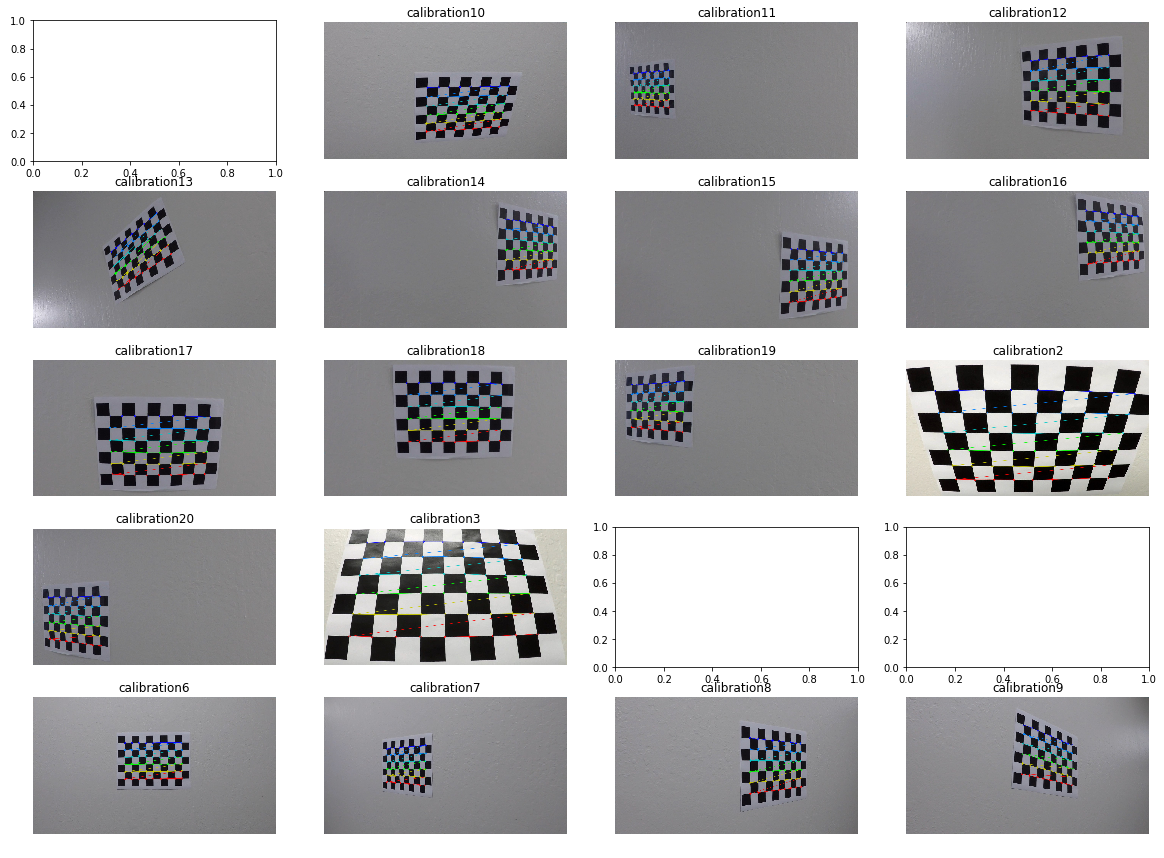

In [235]:
# Read in the calibration images
images = glob.glob('camera_cal/calibration*.jpg')

f, axs = plt.subplots(5,4, figsize=(20, 15))
axs = axs.ravel()

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Prepare object points like (0,0,0), (1,0,0), (2,0,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x,y coordinates

for i, fname in enumerate(images):
    # read in each image
    img = mpimg.imread(fname) 
    #convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6),corners,ret)
        axs[i].axis('off')
        file_name = os.path.splitext(os.path.basename(fname))[0]        
        axs[i].set_title(file_name)
        axs[i].imshow(img)
        
    

#### 2a. Apply a distortion correction to raw images.

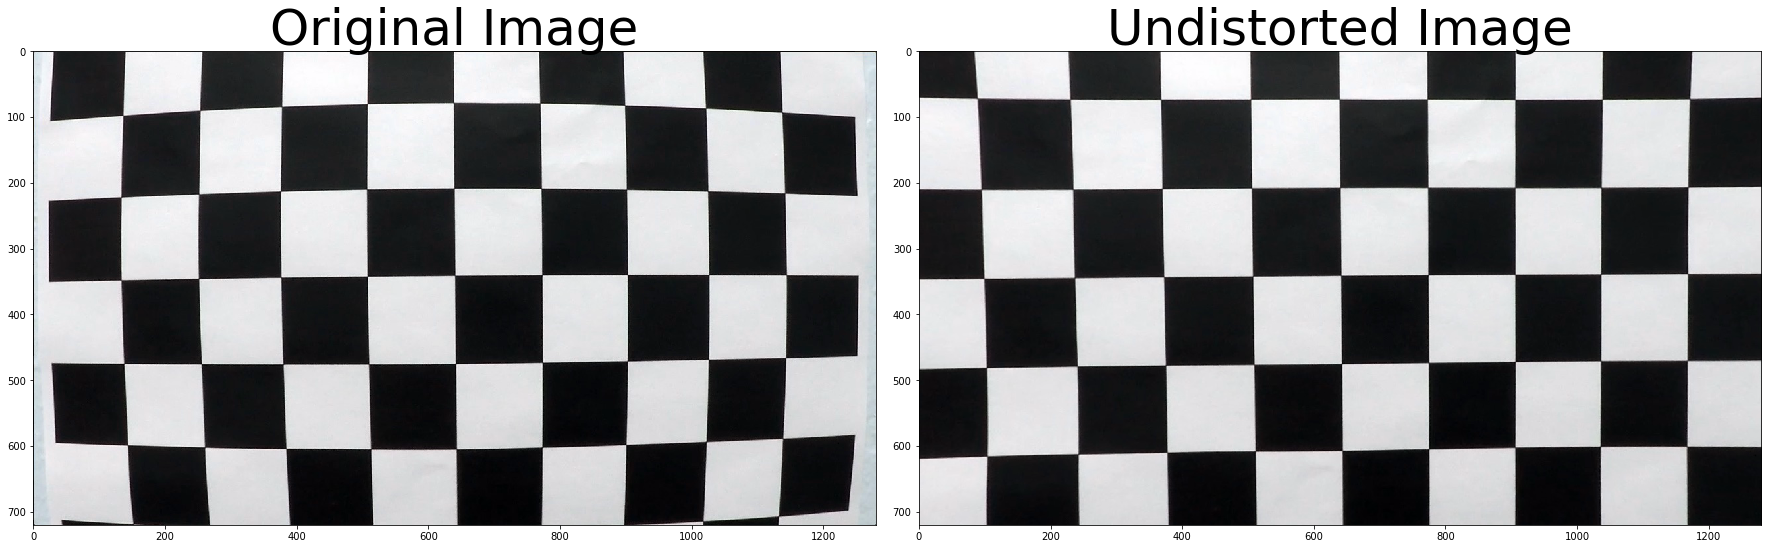

In [236]:
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
img  = cv2.imread('camera_cal/calibration1.jpg')
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)

# save the mtx and dist coefficients
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("calibration.p", "wb"))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Pipeline (test images)

#### 1b.  Provide an example of a distortion-corrected image.

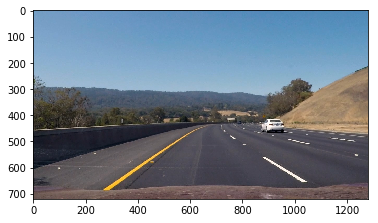

In [237]:
#An example of a distortion corrected image
testImg = cv2.imread('test_images/test3.jpg')
testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)
plt.imshow(testImg)

In [238]:
# undistort the image
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

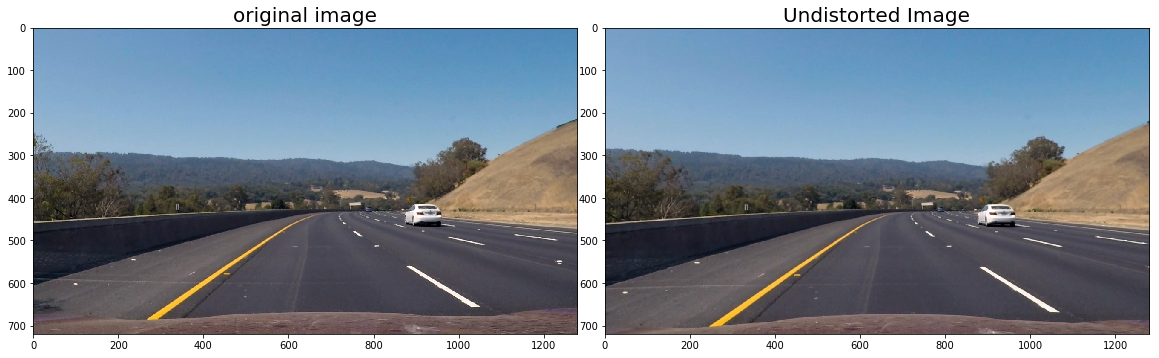

In [239]:
undist = undistort(testImg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.set_title("original image", fontsize=20)
ax1.imshow(testImg)
ax2.set_title("Undistorted Image", fontsize=20)
ax2.imshow(undist)

#### 2b. Perspective Transform

#### Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

In [240]:
# unwarp the image using opencv functions
def unwarp(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

In [241]:
# find the trapezoid co-ordinates on the undistorted image to unwarp the image
h,w = undist.shape[:2]
print(h,w)
# define source and destination points for transform
src = np.float32([(582,474),
                  (734,474), 
                  (272,672), 
                  (1082,672)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

unwarp, M, Minv = unwarp(undist, src, dst)



720 1280


Text(0.5,1,'Unwarped Image')

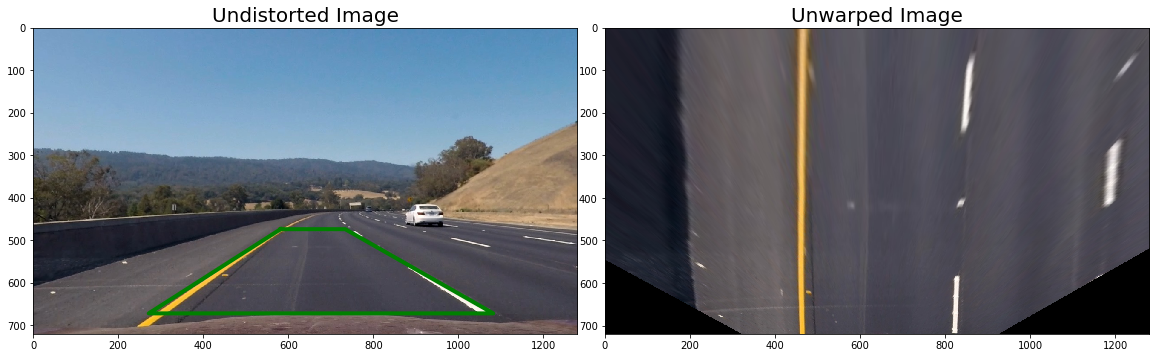

In [242]:
# Visualize correctly rectified image to a "birds-eye view
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='green',linewidth=4)
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(unwarp)
ax2.set_title('Unwarped Image', fontsize=20)


#### 2c. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

#### Color Transform unwarped image

Text(0.5,1,'HSV V-Channel')

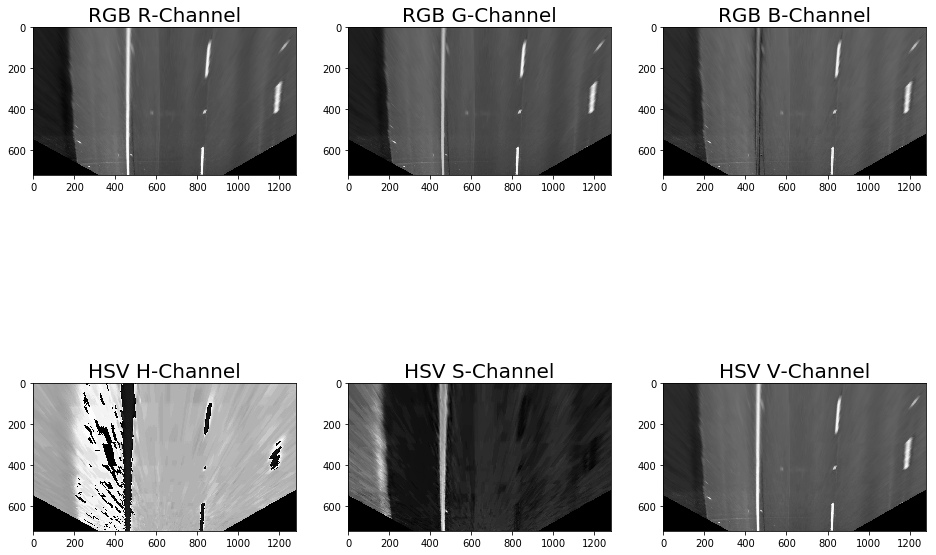

In [243]:
unwarp_HSV = cv2.cvtColor(unwarp, cv2.COLOR_RGB2HSV)

# RGB 
unwarp_R = unwarp[:,:,0]
unwarp_G = unwarp[:,:,1]
unwarp_B = unwarp[:,:,2]

#HSV
unwarp_H = unwarp_HSV[:,:,0]
unwarp_S = unwarp_HSV[:,:,1]
unwarp_V = unwarp_HSV[:,:,2]

# Visualize the channels
fig, axs = plt.subplots(2,3, figsize=(16, 12))
axs = axs.ravel()
axs[0].imshow(unwarp_R, cmap = 'gray')
axs[0].set_title('RGB R-Channel', fontsize=20)
axs[1].imshow(unwarp_G, cmap = 'gray')
axs[1].set_title('RGB G-Channel', fontsize=20)
axs[2].imshow(unwarp_B, cmap = 'gray')
axs[2].set_title('RGB B-Channel', fontsize=20)

#HSV
axs[3].imshow(unwarp_H, cmap = 'gray')
axs[3].set_title('HSV H-Channel', fontsize=20)
axs[4].imshow(unwarp_S, cmap = 'gray')
axs[4].set_title('HSV S-Channel', fontsize=20)
axs[5].imshow(unwarp_V, cmap = 'gray')
axs[5].set_title('HSV V-Channel', fontsize=20)



### Sobel Operator

In [245]:
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

min_thresh = 20
max_thresh = 120
grad_binary = abs_sobel_thresh(unwarp,'x', min_thresh, max_thresh)


#### Visualize Threshold  results

In [246]:
# Visualize the results
# Plot the result

def visualize(org_text, final_text, image, bin_image):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title(org_text, fontsize=30)
    ax2.imshow(bin_image, cmap='gray')
    ax2.set_title(final_text, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Visualize sobel operator

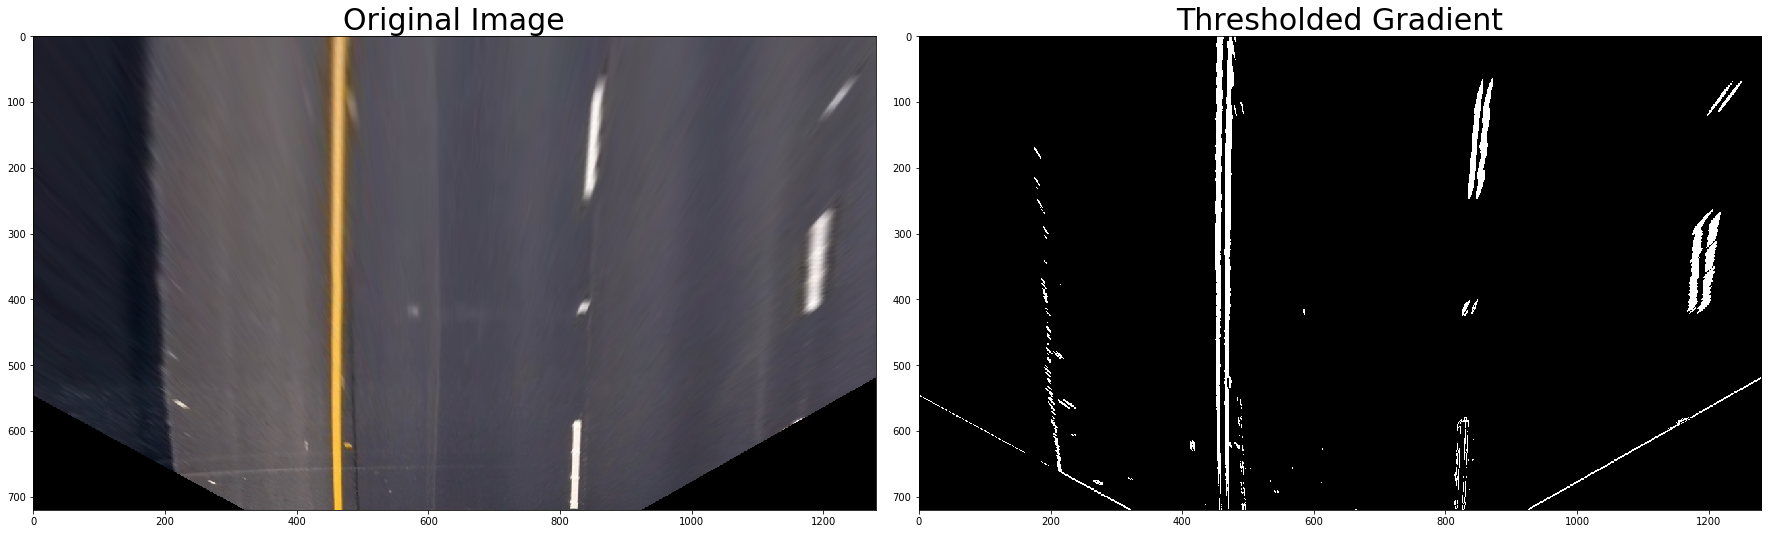

In [247]:
visualize('Original Image','Thresholded Gradient',unwarp,grad_binary)

### Magnitude of the Gradient

In [248]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
     # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
     # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output


min_thresh = 20
max_thresh = 120
mag_binary = mag_thresh(unwarp, 15 ,(min_thresh, max_thresh))

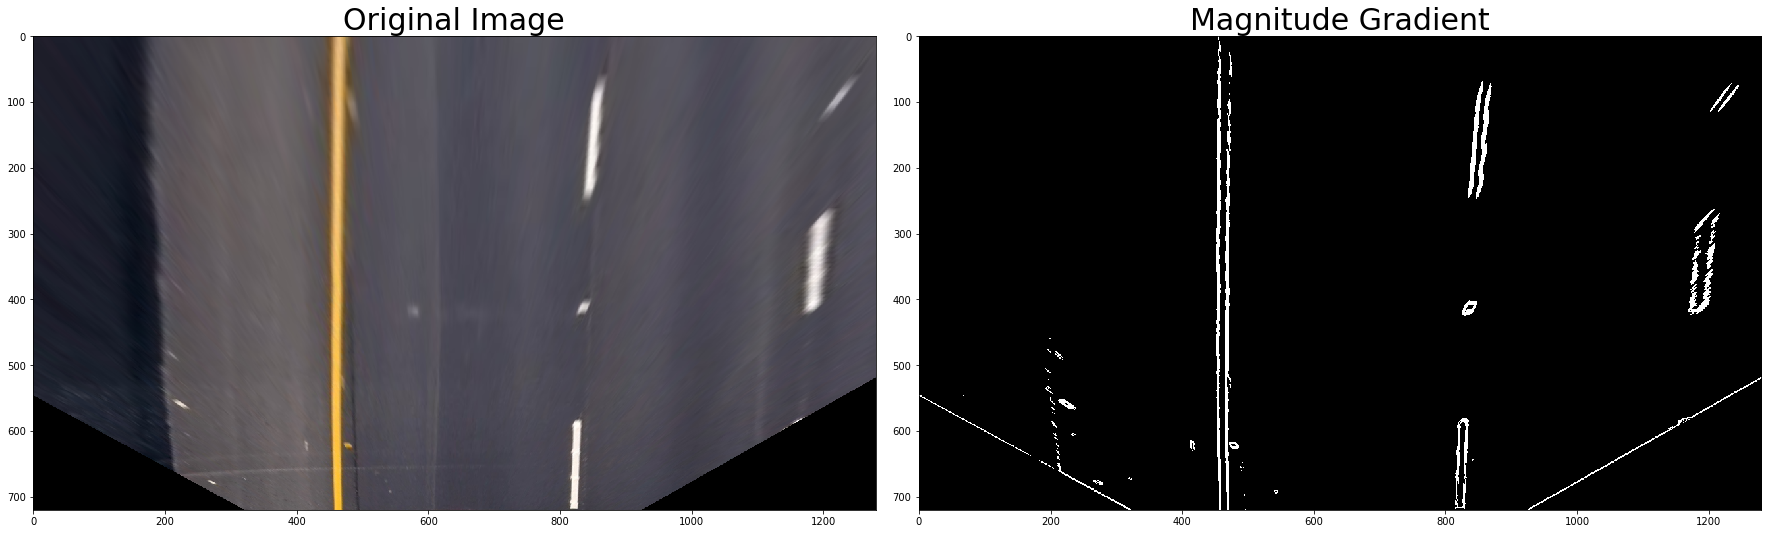

In [249]:
visualize('Original Image','Magnitude Gradient', unwarp, mag_binary)

### Direction of the Gradient

In [258]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
     # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Run the function
dir_binary = dir_threshold(unwarp, sobel_kernel=15, thresh=(0.7, 1.3))

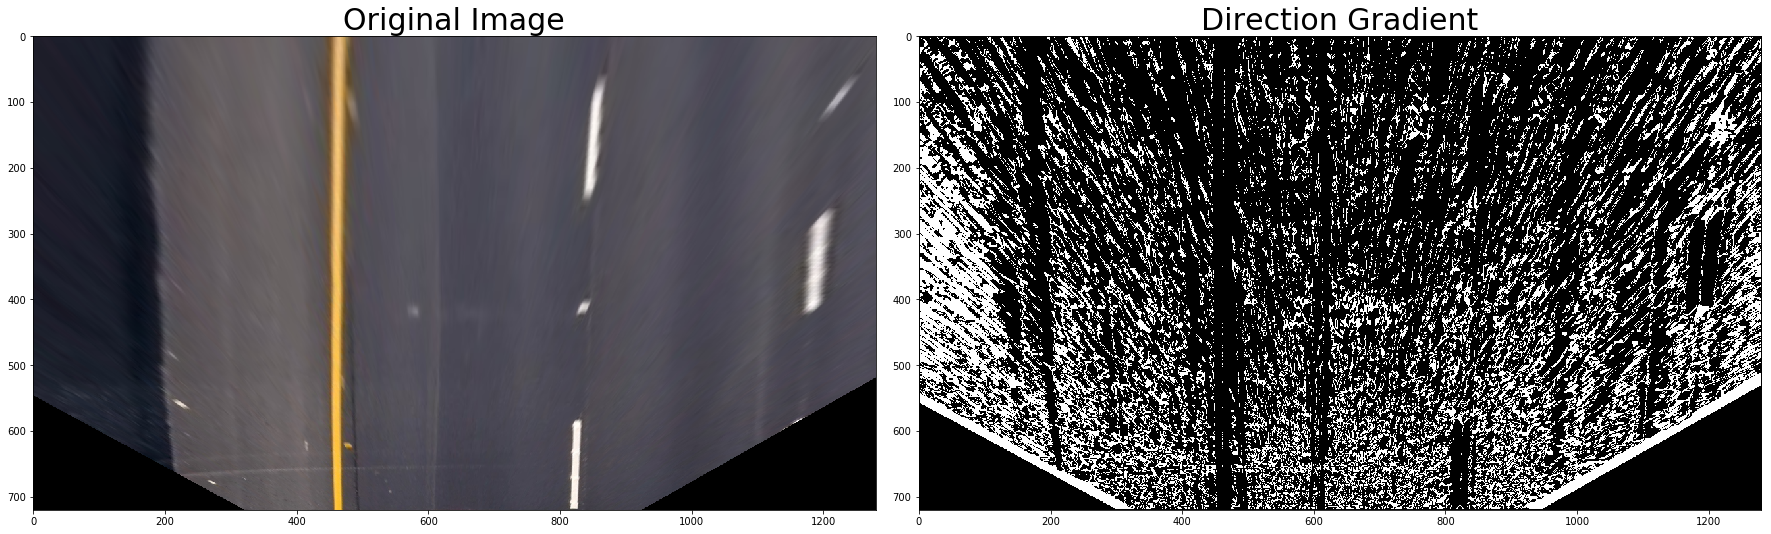

In [259]:
visualize('Original Image','Direction Gradient', unwarp, dir_binary)

#### Sobel Magnitude + Direction

In [290]:
def combined(mag_kernel_size, mag_min_thresh, mag_max_thresh, dir_kernel_size, dir_min_thresh, dir_max_thresh):
    sobelMag = mag_thresh(unwarp, mag_kernel_size, (mag_min_thresh, mag_max_thresh))
    sobelDir = dir_threshold(unwarp, dir_kernel_size, (dir_min_thresh, dir_max_thresh))
    combined = np.zeros_like(sobelMag)
    combined[((sobelMag == 1) & (sobelDir == 1))] = 1
    return combined

mag_kernel_size = 5
dir_kernel_size = 5
mag_min_thresh = 20
mag_max_thresh = 120
dir_min_thresh = 0.03
dir_max_thresh = 0.34

comb_binary = combined(mag_kernel_size, mag_min_thresh, mag_max_thresh, dir_kernel_size, dir_min_thresh, dir_max_thresh)




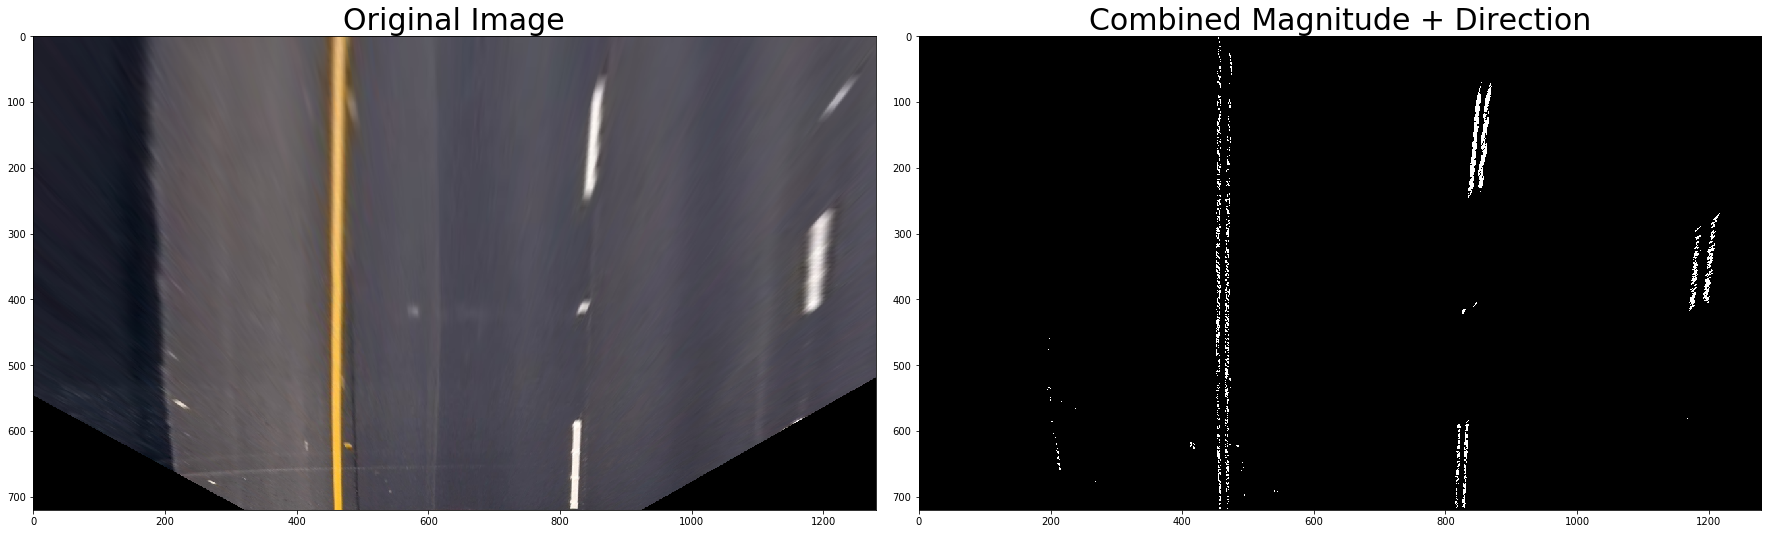

In [291]:
visualize('Original Image','Combined Magnitude + Direction', unwarp, comb_binary)

### Color Channel

In [270]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_sthresh(img, thresh=(125, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output


min_thresh = 125
max_thresh = 255
SThresh = hls_sthresh(unwarp, (min_thresh, max_thresh))


...


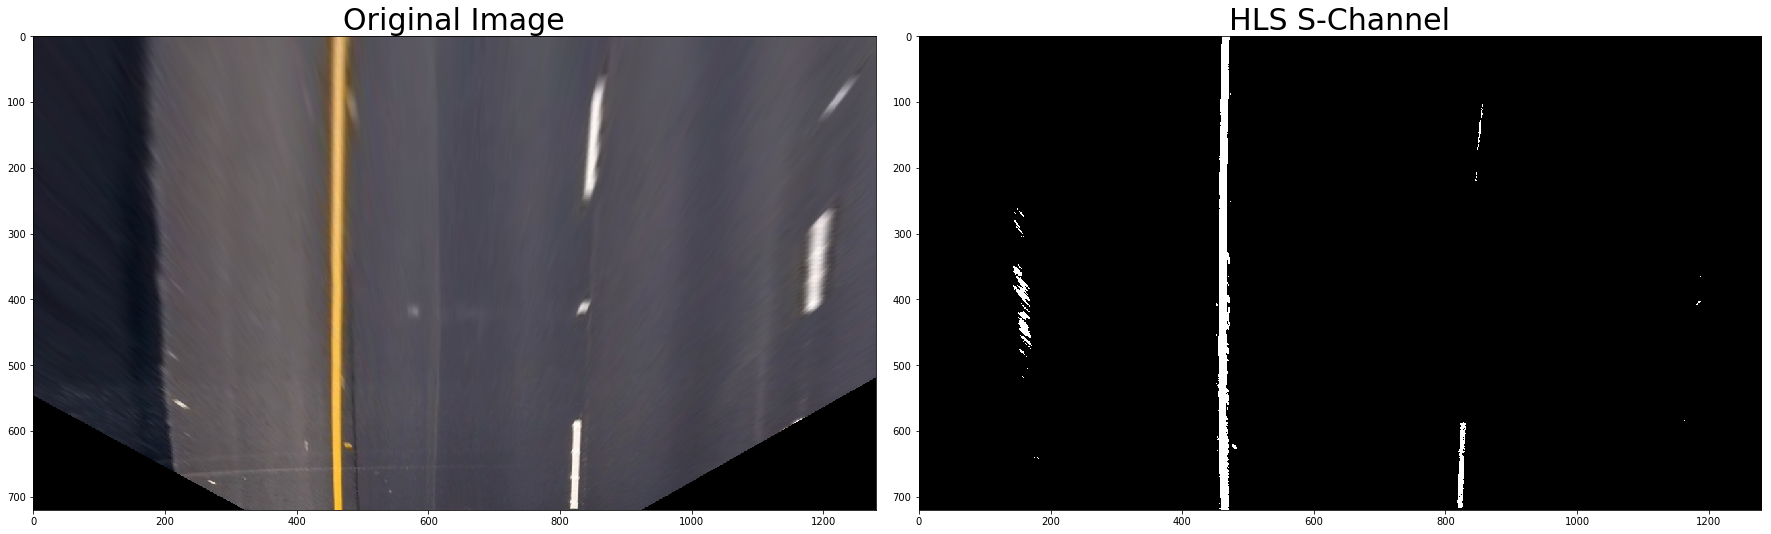

In [271]:
visualize('Original Image','HLS S-Channel', unwarp, SThresh)
print('...')